### Double Standard Model

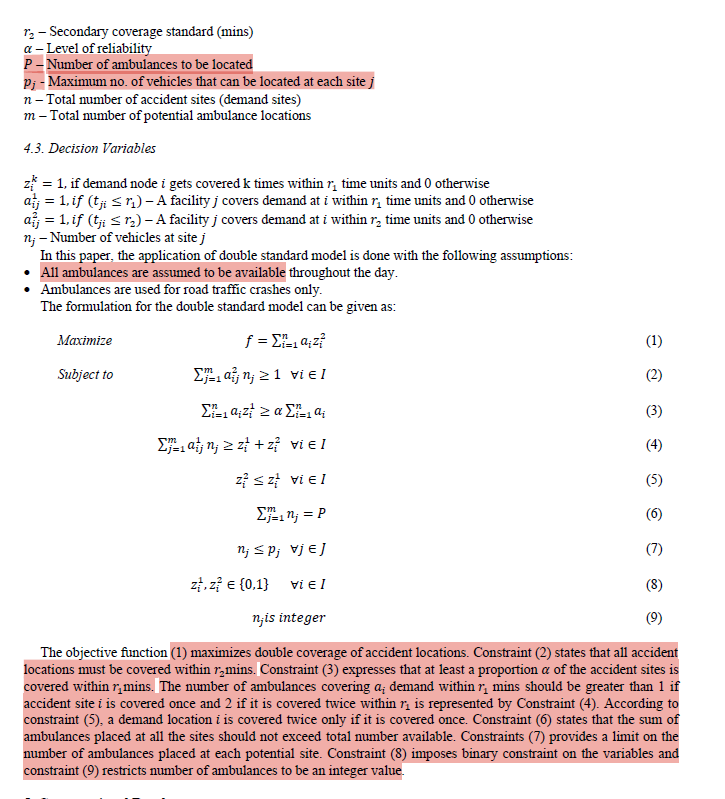

### Primnary coverage time assumed from https://timesofindia.indiatimes.com/city/hyderabad/a-death-every-4-days-on-orr-fatalities-rise-3-fold-in-1-year/articleshow/107650972.cms

In [1]:
import pandas as pd
time_matrix_orsm=pd.read_csv("/workspaces/Accident-Opt-Strabag/DataFiles/Distance_Time_Matrix/osrm_time_matrix.csv") #for osrm based
time_matrix_chainage=pd.read_csv("/workspaces/Accident-Opt-Strabag/DataFiles/Distance_Time_Matrix/chainage_time_matrix.csv") #for chainage based
new_column_names = list(range(0, 16))
time_matrix_chainage.columns = new_column_names
time_matrix_orsm.columns = new_column_names

In [2]:
time_np_chainage=time_matrix_chainage.to_numpy()
time_np_orsm=time_matrix_orsm.to_numpy()

### Shape of the time_np is now 26x16 i=26 j=16

### Accident weights-- sum of accidents each size

In [3]:
clusters=pd.read_csv("/workspaces/Accident-Opt-Strabag/DataFiles/KMeans_clusters.csv")
weights=clusters['Accident_Frequency'].to_list()

In [4]:
weights

[2, 5, 4, 4, 5, 3, 4, 7, 2, 9, 3, 5, 6, 6, 3, 8, 4, 3, 3, 4, 3, 4, 4, 1, 1, 4]

### i--Demand Points- 26 and j--Source- 16

## Variables

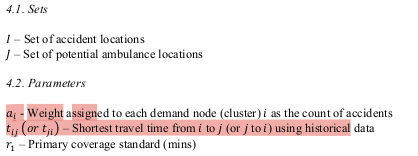

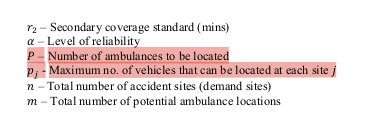

In [49]:
import pulp

n=26 #number of demand points
m=16 #potential sites ambulance location
P=10 #number of amnbulances to be located
alpha=0.8 #reliability Taking 80% coverage within r1 time
a_i = weights #weights at each site
t_ij=time_np_chainage #shortedt time to travel from i to j  TIME MATRIX
r_1= 4 #primary coverage time (mins)
r_2= 6 #secondary coverage time (mins) ASSUMED 
p_j=[] #maximum number of ambulances at each site IT WILL BE 1 for our case now
for i in range(m):
    p_j.append(2)

## Decision variables

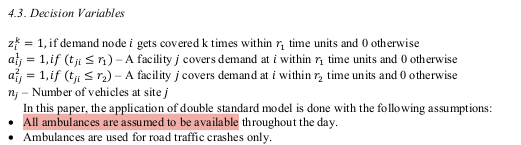

In [50]:
demand_points=[]
for i in range(0,26):
    demand_points.append(i)
source_locations=[] #the potential locations of the ambulances 
for i in range(0,16):
    source_locations.append(i)

# Define the new binary variables z_ij to represent a_ij2 * x_j
z = pulp.LpVariable.dicts("z", [(i, j) for i in demand_points for j in source_locations], 0, 1, pulp.LpBinary)
#new variable to represent a_ij1*n_j 
x=pulp.LpVariable.dicts("x",[(i,j) for i in demand_points for j in source_locations], 0, 1, pulp.LpBinary)


z_i1 = pulp.LpVariable.dicts("z_i1", demand_points, 0, 1, pulp.LpBinary)
z_i2 = pulp.LpVariable.dicts("z_i2", demand_points, 0, 1, pulp.LpBinary)
a_ij1 = pulp.LpVariable.dicts("a_ij1", [(i, j) for i in demand_points for j in source_locations], 0, 1, pulp.LpBinary)
a_ij2 = pulp.LpVariable.dicts("a_ij2", [(i, j) for i in demand_points for j in source_locations], 0, 1, pulp.LpBinary)
n_j = pulp.LpVariable.dicts("n_j", source_locations, 0, 2, pulp.LpInteger)

## Problem function

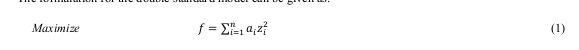

In [51]:
problem=pulp.LpProblem("Ambulance-Coverage-Loc",sense=pulp.LpMaximize)
problem+=pulp.lpSum(a_i[i]*z_i2[i] for i in demand_points)

## Constraints

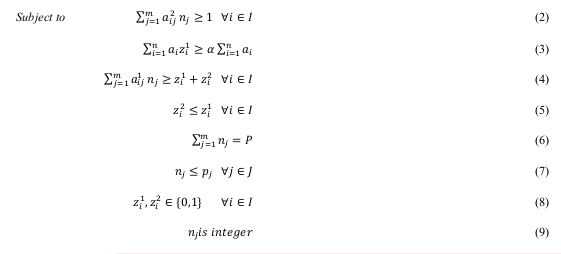

#### PuLP doesn't take only variables comparison as it is--- use LpConstraint as used in 5

In [52]:

for i in demand_points:
    for j in source_locations:
        if t_ij[(i,j)]<=r_2 and n_j[j]!=0:
            problem+= a_ij2[(i,j)]==1
            problem+= z[(i,j)]==n_j[j]
        else:
            problem+= a_ij2[(i,j)]==0
            problem+=z[(i,j)]==0
        if t_ij[(i,j)]<=r_1 and n_j[j]!=0:
            problem+=a_ij1[(i,j)]==1
            problem+=x[(i,j)]==n_j[j]
        else:
            problem+=a_ij1[(i,j)]==0
            problem+=x[(i,j)]==0

#x for a_ij1*n_j z for a_ij2*n_j

# Modify the original constraint to use the new binary variables
for i in demand_points:
    #problem += pulp.lpSum(a_ij2[(i, j)]*n_j for j in source_locations if t_ij[(i, j)] <= r_2) >= 1 #-------------------------------->2
    problem += pulp.lpSum(z[(i, j)] for j in source_locations) >= 1


# Constraints
for i in demand_points:
    problem += pulp.lpSum(a_i[i]*z_i1[i] for j in source_locations if t_ij[(i,j)]<=r_1)>=  alpha* pulp.lpSum(a_i[i]) #---------------------------->3
    #problem += pulp.lpSum(x[(i,j)] for j in source_locations  if t_ij[(i, j)] <= r_1) >= z_i1[i] + z_i2[i] #------------------------>4
    problem += pulp.lpSum(x[(i,j)] for j in source_locations) >= z_i1[i] + z_i2[i]
    #problem += pulp.LpConstraint(z_i2[i]<=z_i1[i]) #------------------------------------>5

for i in demand_points:
    problem += z_i2[i]<=z_i1[i]

for j in range(m):
  #problem += pulp.LpConstraint(n_j[j] <= p_j[j]) #-------------------------->7
  problem += n_j[j] <= p_j[j]

for j in range(m):
    #problem+=pulp.LpConstraint(n_j[j]>=0) #---------------------------------->8
    problem+=n_j[j]>=0


problem += pulp.lpSum(n_j[j] for j in source_locations ) == P #------------------------------>6

In [53]:
problem

Ambulance-Coverage-Loc:
MAXIMIZE
2*z_i2_0 + 5*z_i2_1 + 3*z_i2_10 + 5*z_i2_11 + 6*z_i2_12 + 6*z_i2_13 + 3*z_i2_14 + 8*z_i2_15 + 4*z_i2_16 + 3*z_i2_17 + 3*z_i2_18 + 4*z_i2_19 + 4*z_i2_2 + 3*z_i2_20 + 4*z_i2_21 + 4*z_i2_22 + 1*z_i2_23 + 1*z_i2_24 + 4*z_i2_25 + 4*z_i2_3 + 5*z_i2_4 + 3*z_i2_5 + 4*z_i2_6 + 7*z_i2_7 + 2*z_i2_8 + 9*z_i2_9 + 0
SUBJECT TO
_C1: a_ij2_(0,_0) = 0

_C2: z_(0,_0) = 0

_C3: a_ij1_(0,_0) = 0

_C4: x_(0,_0) = 0

_C5: a_ij2_(0,_1) = 0

_C6: z_(0,_1) = 0

_C7: a_ij1_(0,_1) = 0

_C8: x_(0,_1) = 0

_C9: a_ij2_(0,_2) = 0

_C10: z_(0,_2) = 0

_C11: a_ij1_(0,_2) = 0

_C12: x_(0,_2) = 0

_C13: a_ij2_(0,_3) = 0

_C14: z_(0,_3) = 0

_C15: a_ij1_(0,_3) = 0

_C16: x_(0,_3) = 0

_C17: a_ij2_(0,_4) = 0

_C18: z_(0,_4) = 0

_C19: a_ij1_(0,_4) = 0

_C20: x_(0,_4) = 0

_C21: a_ij2_(0,_5) = 0

_C22: z_(0,_5) = 0

_C23: a_ij1_(0,_5) = 0

_C24: x_(0,_5) = 0

_C25: a_ij2_(0,_6) = 0

_C26: z_(0,_6) = 0

_C27: a_ij1_(0,_6) = 0

_C28: x_(0,_6) = 0

_C29: a_ij2_(0,_7) = 1

_C30: - n_j_7 + z_(0,

In [54]:
problem.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /workspaces/Accident-Opt-Strabag/venv-efkon/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/f8562c9abba042ce9674815327a8842b-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/f8562c9abba042ce9674815327a8842b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1806 COLUMNS
At line 8070 RHS
At line 9872 BOUNDS
At line 11605 ENDATA
Problem MODEL has 1801 rows, 1732 columns and 2773 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.01   (Wallclock seconds):       0.01



-1

In [48]:
# Solve the problem
status = problem.solve()

# Print results
print("Status:", pulp.LpStatus[status])
for j in source_locations:
    print(f"Ambulance at location {j}: {n_j[j].varValue}")

for i in demand_points:
    print(f"Demand point {i} primary coverage (z_i1): {z_i1[i].varValue}")
    print(f"Demand point {i} secondary coverage (z_i2): {z_i2[i].varValue}")

print("Objective function value:", pulp.value(problem.objective))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /workspaces/Accident-Opt-Strabag/venv-efkon/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/47738b957c924fbcb363b012596e5770-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/47738b957c924fbcb363b012596e5770-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1806 COLUMNS
At line 8070 RHS
At line 9872 BOUNDS
At line 11605 ENDATA
Problem MODEL has 1801 rows, 1732 columns and 2773 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.01   (Wallclock seconds):       0.02

Status: Infeasible
Ambulance at location 0: 0.0
Ambulance at location 1: 0.0
Ambulance at location 2: 0.0
Ambulance at location 3: 0.0
Ambulance at location 4: 0.0
Ambulance at location 5: 0.0
Ambul

In [31]:
df_s=pd.read_excel("/workspaces/Accident-Opt-Strabag/DataFiles/sources_hosp_toll.xlsx")

allotment_list=[]
for j in source_locations:
    allotment_list.append(int(n_j[j].varValue))

df=pd.DataFrame({'optimised-ambulances':allotment_list,'lat':df_s['Source_Latitude'],'long':df_s['Source_Longitude']})
df.to_csv("optimised_ambulance_allotment-10.csv")